In [1]:
import csv
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

# featurizer class definition

class Featurizer():
    
    def __init__(self, fp_len, fp_type):
        self.fp_len = fp_len
        self.fp_type = fp_type
    
    def __call__(self, df):
        fingerprints = []
        labels = []
        
        labels = df['Ki']
        fp = []
        for index, row in df.iterrows():
            fp = row[1:self.fp_len+1]
            fingerprints.append(fp)
            
        fingerprints = np.array(fingerprints)
        labels = np.array(labels)
        return fingerprints, labels
        
class KlekFeaturizer(Featurizer):
    def __init__(self, fp_len=4860, fp_type='Klek'):
        super().__init__(fp_len, fp_type)
    
class MACCSFeaturizer(Featurizer):
    def __init__(self, fp_len=166, fp_type='MACCS'):
        super().__init__(fp_len, fp_type)
        
class SubFeaturizer(Featurizer):
    def __init__(self, fp_len=307, fp_type='Sub'):
        super().__init__(fp_len, fp_type)

In [2]:
#file to DataFrame object

filename = 'data/d2_SubFP_final_file.csv'
df = pd.read_csv(filename)
df = df.dropna()

featurizer = SubFeaturizer()
X_train, y_train = featurizer(df)

X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)

assert X_train.shape[0] == y_train.shape[0], 'X_train and y_train rows do not match'

In [3]:
from torch.utils.data import DataLoader, TensorDataset

tensor_ds = TensorDataset(X_train, y_train)
train = tensor_ds

train_dataloader = DataLoader(train, batch_size=64, shuffle=True)

In [13]:
fp_len = featurizer.fp_len # Klek=4860, MACCS=166, Sub=307
code_len = 8 # 1 to 15

class Autoencoder(nn.Module):
    
    torch.set_default_dtype(torch.float64)
    
    def __init__(self, fp_len, code_len):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(fp_len, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, code_len)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(code_len ,16),
            nn.ReLU(),
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, fp_len),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [15]:
def train(train_dataloader):

    epochs = 20
    
    model = Autoencoder(fp_len, code_len)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
    
    for epoch in range(epochs):
        for (fp, _) in train_dataloader:
            encoded, recon = model(fp)
            loss = criterion(recon, fp)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f'Epoch: {epoch+1}, Loss: {loss.item()}')
    
    return model
    
# train

model = train(train_dataloader)

Epoch: 1, Loss: 0.6891405674122996
Epoch: 2, Loss: 0.6819597186129565
Epoch: 3, Loss: 0.6706305010238588
Epoch: 4, Loss: 0.6498044672622622
Epoch: 5, Loss: 0.6034545940635491
Epoch: 6, Loss: 0.517054675076735
Epoch: 7, Loss: 0.3841432428340152
Epoch: 8, Loss: 0.24182807838852324
Epoch: 9, Loss: 0.1577838208358741
Epoch: 10, Loss: 0.11318924634719416
Epoch: 11, Loss: 0.0926099160316004
Epoch: 12, Loss: 0.08108341934010459
Epoch: 13, Loss: 0.07469002806852043
Epoch: 14, Loss: 0.07819593171929684
Epoch: 15, Loss: 0.07485250804342702
Epoch: 16, Loss: 0.06319459109688279
Epoch: 17, Loss: 0.06417957751966875
Epoch: 18, Loss: 0.06434759847411943
Epoch: 19, Loss: 0.05589917577611563
Epoch: 20, Loss: 0.06063522965198318


[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 10750 samples in 0.015s...
[t-SNE] Computed neighbors for 10750 samples in 3.309s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10750
[t-SNE] Computed conditional probabilities for sample 2000 / 10750
[t-SNE] Computed conditional probabilities for sample 3000 / 10750
[t-SNE] Computed conditional probabilities for sample 4000 / 10750
[t-SNE] Computed conditional probabilities for sample 5000 / 10750
[t-SNE] Computed conditional probabilities for sample 6000 / 10750
[t-SNE] Computed conditional probabilities for sample 7000 / 10750
[t-SNE] Computed conditional probabilities for sample 8000 / 10750
[t-SNE] Computed conditional probabilities for sample 9000 / 10750
[t-SNE] Computed conditional probabilities for sample 10000 / 10750
[t-SNE] Computed conditional probabilities for sample 10750 / 10750
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.192s
[t-SNE] Iteration 50: error = 219.34

<Axes: >

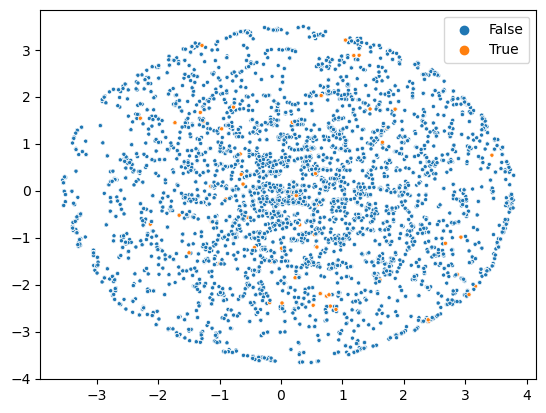

In [16]:
# encode

encoded, recon = model(X_train)

from sklearn.manifold import TSNE
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns

encoded = encoded.detach().numpy()
encoded = np.transpose(encoded)

encoded_df = pd.DataFrame()
for i in range(8):
    encoded_df[f'{i+1}'] = encoded[i]

X_tsne = TSNE(metric='jaccard', perplexity=5, verbose=3).fit_transform(encoded_df)

sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], marker=".", hue=(y_train<1))